In [64]:
import os
import pathlib

from copy import copy
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rampwf.utils.importing import import_module_from_source

from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.func import functional_call, grad

ImportError: cannot import name 'tree_map_' from 'torch.utils._pytree' (/home/abenechehab/anaconda3/envs/mbrl_dmcontrol/lib/python3.8/site-packages/torch/utils/_pytree.py)

In [62]:
!pip install torch==2.2.0 --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.7/186.7 MB 4.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mbrltools 1.0.1.dev28+g53892fa requires torch<2,>=1.13, but you have torch 2.2.0+cpu which is incompatible.
torchvision 0.14.1 requires torch==1.13.1, but you have torch 2.2.0+cpu which is incompatible.


## Working dir

In [ ]:
env_name = "cartpole_dm_numpy"
env_dir = pathlib.Path(os.getcwd()).parent / "envs" / env_name
os.chdir(env_dir) 
os.getcwd()

## Model

In [40]:
class SmallModel(nn.Module):
    def __init__(
        self, 
        input_dim: int = 1, 
        output_dim: int = 1, 
        layer_size: int = 1, 
        n_layers: int = 1, 
        skip_connection: bool = False
    ):
        super(SmallModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.skip_connection = skip_connection
        
        activation = nn.ReLU
        
        self.linear0 = nn.Linear(input_dim, layer_size, bias=True)
        self.act0 = activation()

        self.common_block = nn.Sequential()
        for i in range(int(n_layers)):
            self.common_block.add_module(
                f"linear{i+1}", nn.Linear(layer_size, layer_size)
            )
            self.common_block.add_module(f"act{i+1}", activation())

        self.mu = nn.Linear(layer_size, output_dim, bias=True)
    
    def forward(self, x):
        n_samples = x.shape[0]

        skip_connection_x = copy(x).detach()[:, :self.output_dim]
        
        x = self.linear0(x)
        x = self.act0(x)
        x = self.common_block(x)
        mu = self.mu(x)

        if self.skip_connection:
            mu += skip_connection_x
        
        return mu

#### save initial weights

In [41]:
model = SmallModel(        
    input_dim = 6, 
    output_dim = 5, 
    layer_size = 256, 
    n_layers = 2, 
    skip_connection = False
)
state_dict = model.state_dict()
torch.save(state_dict, 'save_init_weights.pt')

## Data

In [42]:
problem_module_path = 'problem.py'
problem_module = import_module_from_source(problem_module_path, 'problem')
get_train_data = problem_module.get_train_data
get_test_data = problem_module.get_test_data

X_train, y_train = get_test_data(data_label='random', horizon=1, dynamic=True)
X_train = X_train[:,:6]
X_test, y_test = get_test_data(data_label='random', horizon=1, dynamic=True)
X_test = X_test[:,:6]

## Training

##### Hyperparams

In [43]:
model = SmallModel(        
    input_dim = 6, 
    output_dim = 5, 
    layer_size = 256, 
    n_layers = 2, 
    skip_connection = False
)

loaded_state_dict = torch.load('save_init_weights.pt')
model.load_state_dict(loaded_state_dict)

learning_rate = 0.001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_epochs = 300

#### Test

In [50]:
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))

validation_fraction = 0.1
n_samples = len(dataset)

indices = np.arange(n_samples)
np.random.shuffle(indices)

ind_split = int(np.floor((1 - validation_fraction) * n_samples))
train_indices, val_indices = indices[:ind_split], indices[ind_split:]

dataset_valid = torch.utils.data.TensorDataset(*dataset[val_indices])
dataset_train = torch.utils.data.TensorDataset(*dataset[train_indices])

dataset_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=64,
    shuffle=True,
    drop_last=False,
)
dataset_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
    
tracked_losses = []
val_tracked_losses = []
grad_input = []

n_train = len(dataset_train.dataset)

for epoch in tqdm(range(1, 1+n_epochs), desc='training epochs'):
    model.train()

    train_loss = 0
    for i, (x, y) in enumerate(dataset_train):
        model.zero_grad()

        out = model(x)
        loss = loss_fn(y, out)
        train_loss += len(x) * loss.item()

        loss.backward()
        optimizer.step()

        # This accumulate the gradients for the different parameters of the network
        fs = lambda x_in, params: loss_fn(functional_call(model, params, x_in), y)
        grad = grad(fs, argnums=0)(x, params)

        grad_input.append(grad)

    train_loss /= n_train
    tracked_losses.append(train_loss)

    # evaluation
    model.eval()
    with torch.no_grad():
        for _, (x, y) in enumerate(dataset_valid):
            out = model(x)
            loss = loss_fn(y, out)
    val_tracked_losses.append(loss)

training epochs:   0%|          | 0/300 [00:00<?, ?it/s]

NameError: name 'grad' is not defined

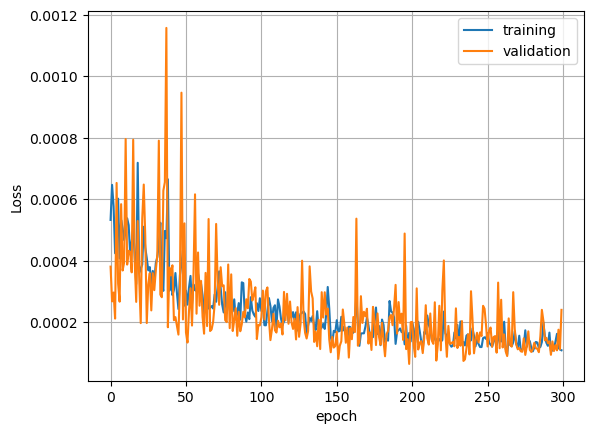

In [49]:
plt.figure()

plt.plot(np.arange(n_epochs), np.array(tracked_losses), label='training')
plt.plot(np.arange(n_epochs), np.array(val_tracked_losses), label='validation')

plt.legend()

plt.xlabel("epoch")
plt.ylabel("Loss")

plt.grid()

plt.show()

In [ ]:
fs = [lambda x, params: loss(functional_call(model, params, x), y) for loss, y in zip(loss_fns, Y)]

# This accumulate the gradients for the different parameters of the network
grads = [grad(f, argnums=1)(X, params) for f in fs]